# Descargar datos de NOAA

In [ ]:
from ftplib import FTP
host = 'ftp2.psl.noaa.gov'
ftp = FTP(host)
ftp.login()
path = '/Datasets/gpcp'
ftp.cwd(path)
filename = 'precip.mon.mean.nc'
#ftp.size(filename)
ftp.retrbinary("RETR " + filename, open(filename, 'wb').write)
ftp.close()

# Tratamiento de datos

## Línea de Tiempo

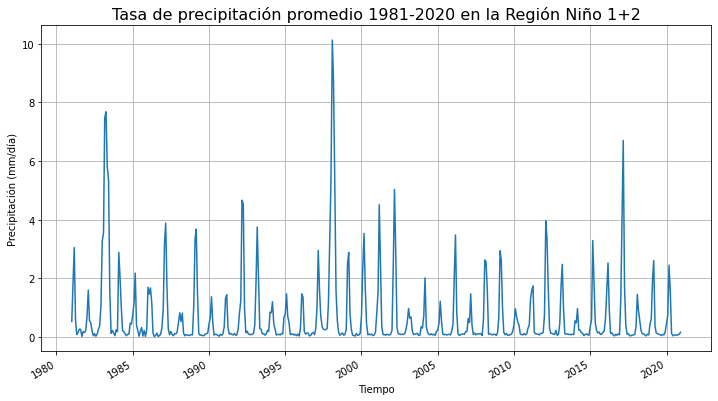

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dset = xr.open_dataset(filename)
data_precip = dset.precip.sel(time=slice("1981-01-01","2020-12-01"), lat=slice(-10,0), lon=slice(270,280))

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
data_precip.mean(dim=['lat','lon']).plot()
ax.set_title("Tasa de precipitación promedio 1981-2020 en la Región Niño 1+2", fontsize=16)
ax.set(xlabel='Tiempo', ylabel='Precipitación (mm/día)')
ax.grid()
#plt.savefig('Precip_LT',bbox_inches='tight',dpi=500)

In [ ]:
dset

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 516)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2021/11 through latest.

### Anomalías de precipitación (1981-2010)

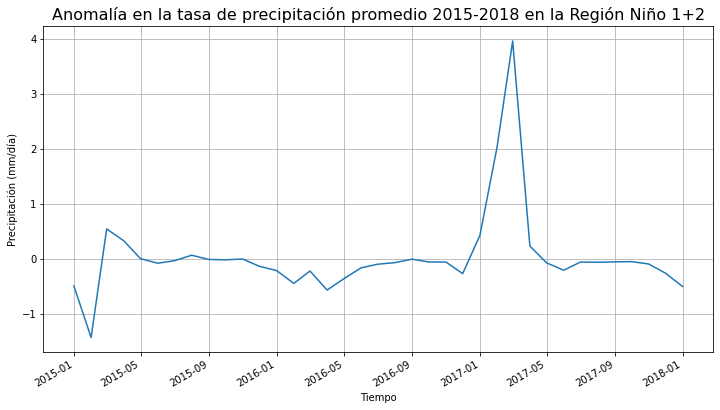

In [ ]:
date_range = pd.date_range("2015-01-01","2018-01-01",freq='MS')
array_data = pd.array(np.zeros(date_range.shape))
#plt.savefig('Anomalía',bbox_inches='tight',dpi=500)

ni=0
for x in date_range:
  month_sel = dset.precip.sel(time=slice(("1981" + str(date_range[ni])[4:10]),
                                      "2010-12-01",12), lat=slice(-10,0), lon=slice(270,280))
  month_sel_norm = month_sel.mean(dim=['time'])
  month_sel_anom = dset.precip.sel(time=date_range[ni], lat=slice(-10,0), lon=slice(270,280)) - month_sel_norm
  array_data[ni] = month_sel_anom.mean(dim=['lon','lat']).values
  ni+=1

new_dset = xr.DataArray(data=array_data, dims=['time'], coords=dict(time=date_range))

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
new_dset.plot()
ax.set_title('Anomalía en la tasa de precipitación promedio 2015-2018 en la Región Niño 1+2', fontsize=16)
ax.set(xlabel='Tiempo', ylabel='Precipitación (mm/día)')
ax.grid()
plt.savefig("Anom_Precip_2015-2018_RegNino1+2", bbox_inches='tight', dpi=500)

## Gráfica de anomalías

In [ ]:
!pip install cartopy
!pip install --no-binary shapely shapely --force

In [ ]:
import cartopy.crs as ccrs

### Anomalías mensuales

Función para calcular la normal

In [ ]:
def precip_month_normal(month):
  month = str(month)
  month_sel = dset.precip.sel(time=slice(("1981-" + month + "-01"),"2010-12-01",12))
  month_normal = month_sel.mean(dim='time')
  return month_normal

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.7/dist-packages/cartopy/mpl/gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4665: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = asanyarray(arr)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4671: ShapelyDeprecationWarning: The array interface is d

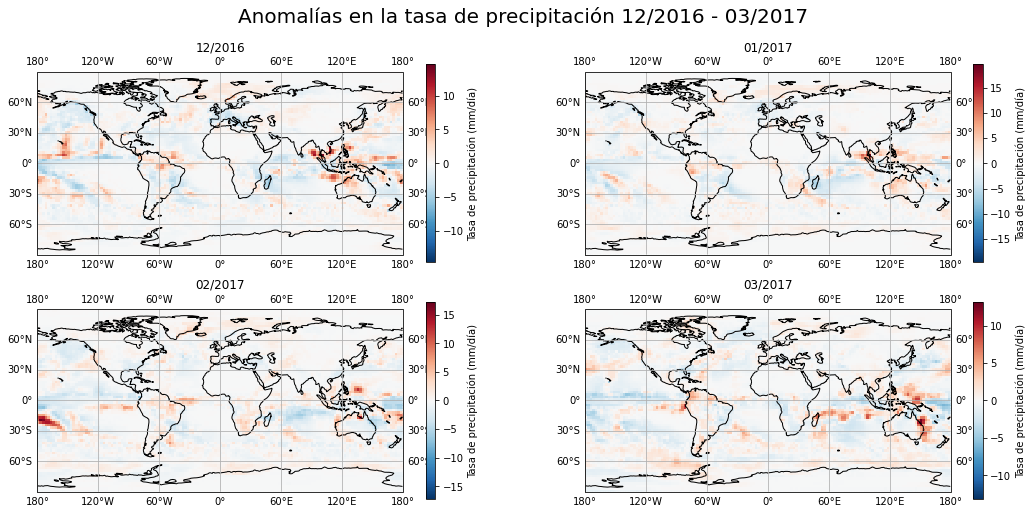

In [ ]:
dec_anom = dset.precip.sel(time='2016-12-01') - precip_month_normal(12)
jan_anom = dset.precip.sel(time='2017-01-01') - precip_month_normal(1)
feb_anom = dset.precip.sel(time='2017-02-01') - precip_month_normal(2)
mar_anom = dset.precip.sel(time='2017-03-01') - precip_month_normal(3)


fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(221, projection= ccrs.PlateCarree())
ax2 = fig.add_subplot(222, projection= ccrs.PlateCarree())
ax3 = fig.add_subplot(223, projection= ccrs.PlateCarree())
ax4 = fig.add_subplot(224, projection= ccrs.PlateCarree())

dec_anom.plot(ax=ax1, transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Tasa de precipitación (mm/día)'))
jan_anom.plot(ax=ax2, transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Tasa de precipitación (mm/día)'))
feb_anom.plot(ax=ax3, transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Tasa de precipitación (mm/día)'))
mar_anom.plot(ax=ax4, transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Tasa de precipitación (mm/día)'))


ax1.set_title("12/2016")
ax2.set_title("01/2017")
ax3.set_title("02/2017")
ax4.set_title("03/2017")

ax1.coastlines()
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
ax2.coastlines()
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
ax3.coastlines()
ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
ax4.coastlines()
ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)

fig.suptitle("Anomalías en la tasa de precipitación 12/2016 - 03/2017", fontsize=20)
plt.savefig("Anom_Precip_Glob_DEFM2017", bbox_inches='tight', dpi=500)

## Gráfica de Hovmöller

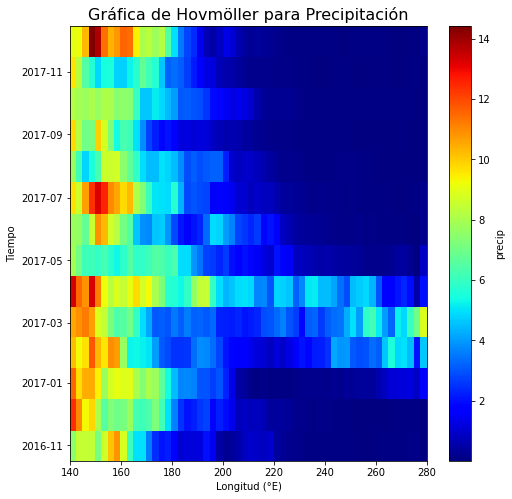

In [ ]:
data_hov = dset.precip.sel(time=slice("2016-11-01","2017-12-01"), lon = slice(140,280), lat=slice(-10,0))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
data_hov.mean(dim='lat').plot(cmap='jet')
ax.set_title("Gráfica de Hovmöller para Precipitación", fontsize=16)
ax.set(xlabel='Longitud (°E)', ylabel='Tiempo')
plt.savefig("Hov_Precip", bbox_inches='tight', dpi=500)